In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from saga import SAGA
from svrg import SVRG
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import StepLR,LambdaLR
from helpers import *
import copy
import time
import pickle
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
MOMENTUM_SAGA = 0.1
MOMENTUM_SGD = 0.9
betas = (0.9,0.999)
N_SAMPLES = 0 #set to 0 to use all dataset
n_channels = 1 # 1 to flatten cifar10
weight_decay = 0.001
data = "cifar10" #"mnist" or "cifar10"
X,y,X_test,y_test,IN_DIM,OUT_DIM = get_data(data,n_channels,N_SAMPLES)
model_str = "LR"
optimal_loss = 1.6123 #best loss at 400k iteration of GD
lr_SGD = 0.0005
lr_CSAGA = 0.001
lr_SVRG = 0.001
lr_Adam = 0.0001
lr_CSAGA_Adam = 0.0001
n_epochs = 30*50000
res_step = int(n_epochs/30)#compute loss,variance and error every step iteration
res_step_var = int(n_epochs/3000)
continue_training = False
centered = "uncentered"
if (centered == "centered"):
    X = (X/127.5) - 1
else:
    X = X/255

if (N_SAMPLES == 0):
    N_SAMPLES = X.shape[0]

Using TensorFlow backend.


In [4]:
print(X.mean())
print(X.min())
print(X.max())
print(X.shape)

0.473362
0.0
1.0
(50000, 3072)


In [5]:
L = (X**2).sum(axis = 1).max()
1/L

0.00033159445932859572

In [6]:
import pandas as pd
print(pd.Series(y).value_counts())

7.0    5000
3.0    5000
5.0    5000
9.0    5000
0.0    5000
8.0    5000
2.0    5000
1.0    5000
4.0    5000
6.0    5000
dtype: int64


In [7]:
class_proba = get_class_proba(y)

In [8]:
class_proba

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1])

In [9]:
class LR(nn.Module):
    def __init__(self,IN_DIM,OUT_DIM):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(IN_DIM, OUT_DIM)
        
    def forward(self, x):
        return self.linear(x)

In [10]:
class NN(nn.Module):
    def __init__(self,in_dim,out_dim):
        super(NN, self).__init__()
        self.mlp = nn.Sequential(
        nn.Linear(in_dim,100),
        nn.ReLU(),
        nn.Linear(100,out_dim)
        )
    
    def forward(self,x):
        return self.mlp(x)

In [11]:
def init_params(model):
    for param in model.parameters():
        param.data.fill_(0)
    return model

In [12]:
if (model_str == 'LR'):
    model = LR
else:
    model = NN
    
criterion = nn.CrossEntropyLoss()
lr_lambda = lambda epoch : 1/np.sqrt(epoch+1)

#if we want to continue training from a saved model, doesn't work though quite yet
if continue_training:
    #load values
    model_SGD_loss = np.load('{}_{}_SGD_loss.npy'.format(model_str,data)).tolist()
    model_CSAGA_loss = np.load('{}_{}_CSAGA_loss.npy'.format(model_str,data)).tolist()
    model_SGD_true_loss = np.load('{}_{}_SGD_true_loss.npy'.format(model_str,data)).tolist()
    model_CSAGA_true_loss = np.load('{}_{}_CSAGA_true_loss.npy'.format(model_str,data)).tolist()
    SGD_avg_var = np.load('{}_{}_SGD_avg_var.npy'.format(model_str,data)).tolist()
    CSAGA_avg_var = np.load('{}_{}_CSAGA_avg_var.npy'.format(model_str,data)).tolist()
    SGD_var = np.asscalar(np.load('{}_{}_SGD_var.npy'.format(model_str,data)))
    CSAGA_var = np.asscalar(np.load('{}_{}_CSAGA_var.npy'.format(model_str,data)))
    model_SGD_test_e = np.load('{}_{}_SGD_test_err.npy'.format(model_str,data)).tolist()
    model_CSAGA_test_e = np.load('{}_{}_CSAGA_test_err.npy'.format(model_str,data)).tolist()
    
    model_Adam_loss = np.load('{}_{}_Adam_loss.npy'.format(model_str,data)).tolist()
    model_CSAGA_Adam_loss = np.load('{}_{}_CSAGA_Adam_loss.npy'.format(model_str,data)).tolist()
    model_Adam_true_loss = np.load('{}_{}_Adam_true_loss.npy'.format(model_str,data)).tolist()
    model_CSAGA_Adam_true_loss = np.load('{}_{}_CSAGA_Adam_true_loss.npy'.format(model_str,data)).tolist()
    Adam_avg_var = np.load('{}_{}_Adam_avg_var.npy'.format(model_str,data)).tolist()
    CSAGA_Adam_avg_var = np.load('{}_{}_CSAGA_Adam_avg_var.npy'.format(model_str,data)).tolist()
    AdamSGD_var = np.asscalar(np.load('{}_{}_Adam_var.npy'.format(model_str,data)))
    CSAGA_Adam_var = np.asscalar(np.load('{}_{}_CSAGA_Adam_var.npy'.format(model_str,data)))
    model_Adam_test_e = np.load('{}_{}_Adam_test_err.npy'.format(model_str,data)).tolist()
    model_CSAGA_Adam_test_e = np.load('{}_{}_CSAGA_Adam_test_err.npy'.format(model_str,data)).tolist()

    #load models
    model_SGD = model(IN_DIM,OUT_DIM)
    model_SGD.load_state_dict(torch.load('{}_{}_model_SGD.pth'.format(model_str,data)))
    model_SGD.to(device)
    model_CSAGA = model(IN_DIM,OUT_DIM)
    model_CSAGA.load_state_dict(torch.load('{}_{}_model_CSAGA.pth'.format(model_str,data)))
    model_CSAGA.to(device)
    model_SVRG = model(IN_DIM,OUT_DIM)
    model_SVRG.load_state_dict(torch.load('{}_{}_model_SVRG.pth'.format(model_str,data)))
    model_SVRG.to(device)
    
    model_Adam = model(IN_DIM,OUT_DIM)
    model_Adam.load_state_dict(torch.load('{}_{}_model_Adam.pth'.format(model_str,data)))
    model_Adam.to(device)
    model_CSAGA_Adam = model(IN_DIM,OUT_DIM)
    model_CSAGA_Adam.load_state_dict(torch.load('{}_{}_model_CSAGA_Adam.pth'.format(model_str,data)))
    model_CSAGA_Adam.to(device)

    #load optimizers
    optimizer_SGD = torch.optim.SGD(model_SGD.parameters(),lr = lr,weight_decay = weight_decay)
    optimizer_SGD.load_state_dict(torch.load('{}_{}_opt_SGD.pth'.format(model_str,data)))
    with open('LR_cifar10_opt_CSAGA.pkl', 'rb') as obj:  
        optimizer_CSAGA = pickle.load(obj)
        
    optimizer_Adam = torch.optim.Adam(model_Adam.parameters(),lr = lr,weight_decay = weight_decay)
    optimizer_Adam.load_state_dict(torch.load('{}_{}_opt_Adam.pth'.format(model_str,data)))
    with open('LR_cifar10_opt_CSAGA_Adam.pkl', 'rb') as obj:  
        optimizer_CSAGA_Adam = pickle.load(obj)

    #load schedulers
    scheduler_SGD = LambdaLR(optimizer_SGD,lr_lambda = lr_lambda)
    scheduler_SGD.load_state_dict(torch.load('{}_{}_sched_SGD.pth'.format(model_str,data)))
    
    scheduler_CSAGA = LambdaLR(optimizer_CSAGA,lr_lambda = lr_lambda)
    scheduler_CSAGA.load_state_dict(torch.load('{}_{}_sched_CSAGA.pth'.format(model_str,data)))
    
    scheduler_Adam = LambdaLR(optimizer_Adam,lr_lambda = lr_lambda)
    scheduler_Adam.load_state_dict(torch.load('{}_{}_sched_Adam.pth'.format(model_str,data)))
    
    scheduler_CSAGA_Adam = LambdaLR(optimizer_CSAGA_Adam,lr_lambda = lr_lambda)
    scheduler_CSAGA_Adam.load_state_dict(torch.load('{}_{}_sched_CSAGA_Adam.pth'.format(model_str,data)))
        
else:
    model_SGD = model(IN_DIM,OUT_DIM).to(device)
    model_SGD_average_w = init_params(model(IN_DIM,OUT_DIM)).to(device)
    model_CSAGA = model(IN_DIM,OUT_DIM).to(device)
    model_CSAGA_average_w = init_params(model(IN_DIM,OUT_DIM)).to(device)
    model_SVRG = model(IN_DIM,OUT_DIM).to(device)
    model_SVRG_average_w = init_params(model(IN_DIM,OUT_DIM)).to(device)    
    model_Adam = model(IN_DIM,OUT_DIM).to(device)
    model_Adam_average_w = init_params(model(IN_DIM,OUT_DIM)).to(device)
    model_CSAGA_Adam = model(IN_DIM,OUT_DIM).to(device)
    model_CSAGA_Adam_average_w = init_params(model(IN_DIM,OUT_DIM)).to(device)
                                                                         
    model_SGD_loss = []
    model_SGD_true_loss = []
    model_SGD_test_e = []
    model_CSAGA_loss = []
    model_CSAGA_true_loss = []
    model_CSAGA_test_e = []    
    model_SVRG_loss = []
    model_SVRG_true_loss = []
    model_SVRG_test_e = []      
    
    model_Adam_loss = []
    model_CSAGA_Adam_loss = []
    model_Adam_true_loss = []
    model_CSAGA_Adam_true_loss = []
    model_Adam_test_e = []
    model_CSAGA_Adam_test_e = []
    
    SGD_avg_var = []
    SGD_var = 0
    CSAGA_avg_var = []
    CSAGA_var = 0   
    SVRG_avg_var = []
    SVRG_var = 0 
    Adam_avg_var = []
    Adam_var = 0
    CSAGA_Adam_avg_var = []
    CSAGA_Adam_var = 0

    optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr = lr_SGD,weight_decay = weight_decay)
    optimizer_CSAGA = SAGA(model_CSAGA.parameters(),
                                  n_classes=OUT_DIM, lr = lr_CSAGA,
                                  class_proba = class_proba,momentum=MOMENTUM_SAGA,compute_var = True,
                                weight_decay = weight_decay)
    optimizer_SVRG = SVRG(model_SVRG.parameters(), lr = lr_SVRG,
                                  momentum=MOMENTUM_SAGA,compute_var = True,
                                weight_decay = weight_decay)
    optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr = lr_Adam,betas = betas,weight_decay = weight_decay)
    optimizer_CSAGA_Adam = SAGA(model_CSAGA_Adam.parameters(),
                                   n_classes=OUT_DIM, lr = lr_CSAGA_Adam,
                              class_proba = class_proba,momentum=MOMENTUM_SAGA,compute_var = True, betas = betas,
                                 use_adam = True,weight_decay = weight_decay)  

    scheduler_SGD = LambdaLR(optimizer_SGD, lr_lambda = lr_lambda)
    scheduler_CSAGA = LambdaLR(optimizer_CSAGA, lr_lambda = lr_lambda)
    scheduler_Adam = LambdaLR(optimizer_Adam , lr_lambda = lr_lambda)
    scheduler_CSAGA_Adam = LambdaLR(optimizer_CSAGA_Adam, lr_lambda = lr_lambda)

In [13]:
def update_weight_average(model,model_average_params,iteration):
    for (model_w,average_w) in zip(list(model.parameters()),list(model_average_params.parameters())):
        average_w.data = average_w.data + iteration*(model_w.data)

In [14]:
def loss_from_average(model_average_params,iteration,inputs,labels,criterion):
    model_copy = copy.deepcopy(model_average_params)
    for w in list(model_copy.parameters()):
            w.data = 2*w.data/(iteration*(iteration+1))
    outputs = model_copy.forward(inputs)
    loss = criterion(outputs, labels) 
    return loss

In [15]:
def compute_error(model,X,y):
    pred = model.forward(torch.Tensor(X_test).to(device))
    pred = (torch.max(pred.data,1)[1]).cpu().numpy()
    e = (y != pred).sum()
    return e/X.shape[0]

In [16]:
compute_error(model_SGD,X_test,y_test)

0.87990000000000002

In [17]:
#train SGD
tstart = time.process_time()
for epoch in range(n_epochs):
    idx = np.random.randint(X.shape[0])
    inputs = torch.from_numpy(X)[idx].to(device)
    labels = torch.tensor(y, dtype=torch.long)[idx].view(1).to(device)
    outputs = model_SGD.forward(inputs).view(1,-1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_SGD.step()
    #variance
    if ((epoch % res_step_var) == 0):
        for param_group in list(model_SGD.parameters()):
            SGD_var += (param_group.grad.data**2).sum()
        SGD_avg_var.append(SGD_var/(epoch/res_step_var+1))
    #losses
    if ((epoch % res_step) == 0):
        inputs = torch.from_numpy(X).to(device)
        labels = torch.tensor(y, dtype=torch.long).to(device)
        #true loss
        outputs = model_SGD.forward(inputs)
        loss = criterion(outputs, labels)
        model_SGD_true_loss.append(loss.data.item())
        #average loss
        update_weight_average(model_SGD,model_SGD_average_w, iteration = (epoch/res_step+1))
        loss = loss_from_average(model_SGD_average_w,(epoch/res_step+1),inputs,labels,criterion)
        model_SGD_loss.append(loss.data.item())
    optimizer_SGD.zero_grad()
    #error
    if ((epoch % res_step) == 0):
#         model_SGD_test_e.append(compute_error(model_SGD,X_test,y_test))
        model_SGD_test_e.append(compute_error(model_SGD_average_w,X_test,y_test))
    if (epoch != 0 and (epoch % N_SAMPLES) == 0):
        for param_group in optimizer_SGD.param_groups:
            print("lr:",param_group['lr'])
        #scheduler_SGD.step()
print('SGD Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
np.save('{}_{}_SGD_loss.npy'.format(model_str,data),np.asarray(model_SGD_loss))
np.save('{}_{}_SGD_true_loss.npy'.format(model_str,data),np.asarray(model_SGD_true_loss))
np.save('{}_{}_SGD_avg_var.npy'.format(model_str,data),np.asarray(SGD_avg_var))
np.save('{}_{}_SGD_test_err.npy'.format(model_str,data),np.asarray(model_SGD_test_e))

lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
lr: 0.0005
SGD Elapsed time: 553.52s


In [18]:
#train C-SAGA
tstart = time.process_time()
for epoch in range(n_epochs):
    idx = np.random.randint(X.shape[0])
    inputs = torch.from_numpy(X)[idx].to(device)
    labels = torch.tensor(y, dtype=torch.long)[idx].view(1).to(device)
    label = int(labels.item())
    outputs = model_CSAGA.forward(inputs).view(1,-1)
    loss = criterion(outputs, labels)
    loss.backward()
    _, var = optimizer_CSAGA.step(idx = label)
    #variance
    if ((epoch % res_step_var) == 0):
        CSAGA_var += var
        CSAGA_avg_var.append(CSAGA_var/(epoch/res_step_var+1))
    #losses
    if ((epoch % res_step) == 0):
        inputs = torch.from_numpy(X).to(device)
        labels = torch.tensor(y, dtype=torch.long).to(device)
        #true loss
        outputs = model_CSAGA.forward(inputs)
        loss = criterion(outputs, labels)
        model_CSAGA_true_loss.append(loss.data.item())
        #average loss
        update_weight_average(model_CSAGA,model_CSAGA_average_w, iteration = (epoch/res_step+1))
        loss = loss_from_average(model_CSAGA_average_w,(epoch/res_step+1),inputs,labels,criterion)
        model_CSAGA_loss.append(loss.data.item())
    optimizer_CSAGA.zero_grad()
    #error
    if ((epoch % res_step) == 0):
#         model_CSAGA_test_e.append(compute_error(model_CSAGA,X_test,y_test))
        model_CSAGA_test_e.append(compute_error(model_CSAGA_average_w,X_test,y_test))
    if (epoch != 0 and (epoch % N_SAMPLES) == 0):
        for param_group in optimizer_CSAGA.param_groups:
            print("lr:",param_group['lr'])
        #scheduler_CSAGA.step()
print('C-SAGA Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
np.save('{}_{}_CSAGA_loss.npy'.format(model_str,data),np.asarray(model_CSAGA_loss))
np.save('{}_{}_CSAGA_true_loss.npy'.format(model_str,data),np.asarray(model_CSAGA_true_loss))
np.save('{}_{}_CSAGA_avg_var.npy'.format(model_str,data),np.asarray(CSAGA_avg_var))
np.save('{}_{}_CSAGA_test_err.npy'.format(model_str,data),np.asarray(model_CSAGA_test_e))

lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
lr: 0.001
C-SAGA Elapsed time: 1022.98s


In [19]:
#train SVRG
tstart = time.process_time()
for epoch in range(n_epochs):
    #snapshot
    if (epoch % N_SAMPLES == 0):
        model_snapshot = copy.deepcopy(model_SVRG)
        model_snapshot_avg = copy.deepcopy(model_snapshot)
        model_snapshot_avg.zero_grad()
        inputs = torch.from_numpy(X).to(device)
        labels = torch.tensor(y, dtype=torch.long).to(device)
        outputs = model_snapshot_avg.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_snapshot.zero_grad()
        model_SVRG.zero_grad()
    idx = np.random.randint(X.shape[0])
    inputs = torch.from_numpy(X)[idx].to(device)
    labels = torch.tensor(y, dtype=torch.long)[idx].view(1).to(device)
    #snapshot grad
    outputs = model_snapshot.forward(inputs).view(1,-1)
    loss = criterion(outputs, labels)
    loss.backward()
    #current grad
    outputs = model_SVRG.forward(inputs).view(1,-1)
    loss = criterion(outputs, labels)
    loss.backward()
    #print("EPOCH",epoch)
    _, var = optimizer_SVRG.step(snap_grad = list(model_snapshot.parameters()),
                                 snap_avg_grad = list(model_snapshot_avg.parameters()))
    #variance
    if ((epoch % res_step_var) == 0):
        SVRG_var += var
        SVRG_avg_var.append(SVRG_var/(epoch/res_step_var+1))
    #losses
    if ((epoch % res_step) == 0):
        inputs = torch.from_numpy(X).to(device)
        labels = torch.tensor(y, dtype=torch.long).to(device)
        #true loss
        outputs = model_SVRG.forward(inputs)
        loss = criterion(outputs, labels)
        model_SVRG_true_loss.append(loss.data.item())
        #average loss
        update_weight_average(model_SVRG,model_SVRG_average_w, iteration = (epoch/res_step+1))
        loss = loss_from_average(model_SVRG_average_w,(epoch/res_step+1),inputs,labels,criterion)
        model_SVRG_loss.append(loss.data.item())
    optimizer_SVRG.zero_grad()
    model_snapshot.zero_grad()
    #error
    if ((epoch % res_step) == 0):
#         model_CSAGA_test_e.append(compute_error(model_CSAGA,X_test,y_test))
        model_SVRG_test_e.append(compute_error(model_SVRG_average_w,X_test,y_test))
    #if (epoch != 0 and (epoch % N_SAMPLES) == 0):
    #    for param_group in optimizer_SVRG.param_groups:
    #        print("lr:",param_group['lr'])
    #    scheduler_SVRG.step()
print('SVRG Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
np.save('{}_{}_SVRG_loss.npy'.format(model_str,data),np.asarray(model_SVRG_loss))
np.save('{}_{}_SVRG_true_loss.npy'.format(model_str,data),np.asarray(model_SVRG_true_loss))
np.save('{}_{}_SVRG_avg_var.npy'.format(model_str,data),np.asarray(SVRG_avg_var))
np.save('{}_{}_SVRG_test_err.npy'.format(model_str,data),np.asarray(model_SVRG_test_e))

SVRG Elapsed time: 1089.82s


#train Adam
tstart = time.process_time()
for epoch in range(n_epochs):
    idx = np.random.randint(X.shape[0])
    inputs = torch.from_numpy(X)[idx].to(device)
    labels = torch.tensor(y, dtype=torch.long)[idx].view(1).to(device)
    outputs = model_Adam.forward(inputs).view(1,-1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_Adam.step()
    #variance
    if ((epoch % res_step_var) == 0):
        for param_group in list(model_Adam.parameters()):
            Adam_var += (param_group.grad.data**2).sum()
        Adam_avg_var.append(Adam_var/(epoch/res_step_var+1))
    #losses
    if ((epoch % res_step) == 0):
        inputs = torch.from_numpy(X).to(device)
        labels = torch.tensor(y, dtype=torch.long).to(device)
        #true loss
        outputs = model_Adam.forward(inputs)
        loss = criterion(outputs, labels)
        model_Adam_true_loss.append(loss.data.item())
        #average loss
        update_weight_average(model_Adam,model_Adam_average_w, iteration = (epoch/res_step+1))
        loss = loss_from_average(model_Adam_average_w,(epoch/res_step+1),inputs,labels,criterion)
        model_Adam_loss.append(loss.data.item())
    optimizer_Adam.zero_grad()
    #error
    if ((epoch % res_step) == 0):
#         model_Adam_test_e.append(compute_error(model_Adam,X_test,y_test))
        model_Adam_test_e.append(compute_error(model_Adam_average_w,X_test,y_test))
    if (epoch != 0 and (epoch % N_SAMPLES) == 0):
        for param_group in optimizer_Adam.param_groups:
            print("lr:",param_group['lr'])
        scheduler_Adam.step()
print('Adam Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
np.save('{}_{}_Adam_loss.npy'.format(model_str,data),np.asarray(model_Adam_loss))
np.save('{}_{}_Adam_true_loss.npy'.format(model_str,data),np.asarray(model_Adam_true_loss))
np.save('{}_{}_Adam_avg_var.npy'.format(model_str,data),np.asarray(Adam_avg_var))
np.save('{}_{}_Adam_test_err.npy'.format(model_str,data),np.asarray(model_Adam_test_e))

#train C-SAGA Adam
tstart = time.process_time()
for epoch in range(n_epochs):
    idx = np.random.randint(X.shape[0])
    inputs = torch.from_numpy(X)[idx].to(device)
    labels = torch.tensor(y, dtype=torch.long)[idx].view(1).to(device)
    label = int(labels.item())
    outputs = model_CSAGA_Adam.forward(inputs).view(1,-1)
    loss = criterion(outputs, labels)
    loss.backward()
    _, var = optimizer_CSAGA_Adam.step(idx = label)
    #variance
    if ((epoch % res_step_var) == 0):
        CSAGA_Adam_var += var
        CSAGA_Adam_avg_var.append(CSAGA_Adam_var/(epoch/res_step_var+1))
    #loss
    if ((epoch % res_step) == 0):
        inputs = torch.from_numpy(X).to(device)
        labels = torch.tensor(y, dtype=torch.long).to(device)
        #true loss
        outputs = model_CSAGA_Adam.forward(inputs)
        loss = criterion(outputs, labels)
        model_CSAGA_Adam_true_loss.append(loss.data.item())
        #average loss
        update_weight_average(model_CSAGA_Adam,model_CSAGA_Adam_average_w, iteration = (epoch/res_step+1))
        loss = loss_from_average(model_CSAGA_Adam_average_w,(epoch/res_step+1),inputs,labels,criterion)
        model_CSAGA_Adam_loss.append(loss.data.item())
    optimizer_CSAGA_Adam.zero_grad()
    #error
    if ((epoch % res_step) == 0):
#         model_CSAGA_Adam_test_e.append(compute_error(model_CSAGA_Adam,X_test,y_test))
        model_CSAGA_Adam_test_e.append(compute_error(model_CSAGA_Adam_average_w,X_test,y_test))
    if (epoch != 0 and (epoch % N_SAMPLES) == 0):
        for param_group in optimizer_CSAGA_Adam.param_groups:
            print("lr:",param_group['lr'])
        scheduler_CSAGA_Adam.step()
print('C-SAGA Adam Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
np.save('{}_{}_CSAGA_Adam_loss.npy'.format(model_str,data),np.asarray(model_CSAGA_Adam_loss))
np.save('{}_{}_CSAGA_Adam_true_loss.npy'.format(model_str,data),np.asarray(model_CSAGA_Adam_true_loss))
np.save('{}_{}_CSAGA_Adam_avg_var.npy'.format(model_str,data),np.asarray(CSAGA_Adam_avg_var))
np.save('{}_{}_CSAGA_Adam_test_err.npy'.format(model_str,data),np.asarray(model_CSAGA_Adam_test_e))

In [20]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [21]:
#save results
# np.save('{}_{}_SGD_loss.npy'.format(model_str,data),np.asarray(model_SGD_loss))
# np.save('{}_{}_CSAGA_loss.npy'.format(model_str,data),np.asarray(model_CSAGA_loss))
# np.save('{}_{}_SGD_true_loss.npy'.format(model_str,data),np.asarray(model_SGD_true_loss))
# np.save('{}_{}_CSAGA_true_loss.npy'.format(model_str,data),np.asarray(model_CSAGA_true_loss))
# np.save('{}_{}_SGD_avg_var.npy'.format(model_str,data),np.asarray(SGD_avg_var))
# np.save('{}_{}_CSAGA_avg_var.npy'.format(model_str,data),np.asarray(CSAGA_avg_var))
# # np.save('{}_{}_SGD_var.npy'.format(model_str,data),np.asarray(SGD_var))
# # np.save('{}_{}_CSAGA_var.npy'.format(model_str,data),np.asarray(CSAGA_var))
# np.save('{}_{}_SGD_test_err.npy'.format(model_str,data),np.asarray(model_SGD_test_e))
# np.save('{}_{}_CSAGA_test_err.npy'.format(model_str,data),np.asarray(model_CSAGA_test_e))

# np.save('{}_{}_Adam_loss.npy'.format(model_str,data),np.asarray(model_Adam_loss))
# np.save('{}_{}_CSAGA_Adam_loss.npy'.format(model_str,data),np.asarray(model_CSAGA_Adam_loss))
# np.save('{}_{}_Adam_true_loss.npy'.format(model_str,data),np.asarray(model_Adam_true_loss))
# np.save('{}_{}_CSAGA_Adam_true_loss.npy'.format(model_str,data),np.asarray(model_CSAGA_Adam_true_loss))
# np.save('{}_{}_Adam_avg_var.npy'.format(model_str,data),np.asarray(Adam_avg_var))
# np.save('{}_{}_CSAGA_Adam_avg_var.npy'.format(model_str,data),np.asarray(CSAGA_Adam_avg_var))
# # np.save('{}_{}_Adam_var.npy'.format(model_str,data),np.asarray(Adam_var))
# # np.save('{}_{}_CSAGA_Adam_var.npy'.format(model_str,data),np.asarray(CSAGA_Adam_var))
# np.save('{}_{}_Adam_test_err.npy'.format(model_str,data),np.asarray(model_Adam_test_e))
# np.save('{}_{}_CSAGA_Adam_test_err.npy'.format(model_str,data),np.asarray(model_CSAGA_Adam_test_e))

# #save models
# torch.save(model_SGD.state_dict(), '{}_{}_model_SGD.pth'.format(model_str,data))
# torch.save(model_CSAGA.state_dict(), '{}_{}_model_CSAGA.pth'.format(model_str,data))
# torch.save(model_Adam.state_dict(), '{}_{}_model_Adam.pth'.format(model_str,data))
# torch.save(model_CSAGA.state_dict(), '{}_{}_model_CSAGA_Adam.pth'.format(model_str,data))

# #save optimizers
# torch.save(optimizer_SGD.state_dict(), '{}_{}_opt_SGD.pth'.format(model_str,data))
# save_object(optimizer_CSAGA, '{}_{}_opt_CSAGA.pkl'.format(model_str,data))
# torch.save(optimizer_Adam.state_dict(), '{}_{}_opt_Adam.pth'.format(model_str,data))
# save_object(optimizer_CSAGA_Adam, '{}_{}_opt_CSAGA_Adam.pkl'.format(model_str,data))

# #save schedulers
# torch.save(scheduler_SGD.state_dict(), '{}_{}_sched_SGD.pth'.format(model_str,data))
# torch.save(scheduler_CSAGA.state_dict(), '{}_{}_sched_CSAGA.pth'.format(model_str,data))
# torch.save(scheduler_SGD.state_dict(), '{}_{}_sched_Adam.pth'.format(model_str,data))
# torch.save(scheduler_CSAGA.state_dict(), '{}_{}_sched_CSAGA_Adam.pth'.format(model_str,data))

In [22]:
# model_SGD_loss = np.load('{}_{}_SGD_loss.npy'.format(model_str,data)).tolist()
# model_CSAGA_loss = np.load('{}_{}_CSAGA_loss.npy'.format(model_str,data)).tolist()
# model_SGD_true_loss = np.load('{}_{}_SGD_true_loss.npy'.format(model_str,data)).tolist()
# model_CSAGA_true_loss = np.load('{}_{}_CSAGA_true_loss.npy'.format(model_str,data)).tolist()
# SGD_avg_var = np.load('{}_{}_SGD_avg_var.npy'.format(model_str,data)).tolist()
# CSAGA_avg_var = np.load('{}_{}_CSAGA_avg_var.npy'.format(model_str,data)).tolist()
# model_SGD_test_e = np.load('{}_{}_SGD_test_err.npy'.format(model_str,data)).tolist()
# model_CSAGA_test_e = np.load('{}_{}_CSAGA_test_err.npy'.format(model_str,data)).tolist()

# model_Adam_loss = np.load('{}_{}_Adam_loss.npy'.format(model_str,data)).tolist()
# model_CSAGA_Adam_loss = np.load('{}_{}_CSAGA_Adam_loss.npy'.format(model_str,data)).tolist()
# model_Adam_true_loss = np.load('{}_{}_Adam_true_loss.npy'.format(model_str,data)).tolist()
# model_CSAGA_Adam_true_loss = np.load('{}_{}_CSAGA_Adam_true_loss.npy'.format(model_str,data)).tolist()
# Adam_avg_var = np.load('{}_{}_Adam_avg_var.npy'.format(model_str,data)).tolist()
# CSAGA_Adam_avg_var = np.load('{}_{}_CSAGA_Adam_avg_var.npy'.format(model_str,data)).tolist()
# model_Adam_test_e = np.load('{}_{}_Adam_test_err.npy'.format(model_str,data)).tolist()
# model_CSAGA_Adam_test_e = np.load('{}_{}_CSAGA_Adam_test_err.npy'.format(model_str,data)).tolist()

In [23]:
#plot with hyperparam information
def plot_val(losses, labels, value = "Loss"):
    plt.figure(figsize=(15,5))
    for loss, label in zip(losses, labels):
        if len(loss) != 0:
            print(label,loss[-1])
        plt.plot(loss, label = label)
    plt.legend(loc='upper right')
    if (N_SAMPLES == 0):
        n_s = "all"
    else:
        n_s = N_SAMPLES
    plt.title('{} {} {} training {} SAGA ({}) (weight decay: {}, n_samples = {})'.format(model_str,
                    data,centered,value,betas,weight_decay, n_s))
    plt.xlabel('iteration/{}'.format(res_step))
    plt.ylabel(value)
    #plt.yscale('log')

SGD (lr:0.0005) 1.6410785913467407
C-SAGA (gradient momentum : 0.1, lr:0.001) 1.6280642747879028
SVRG (lr:0.001) 1.6253116130828857


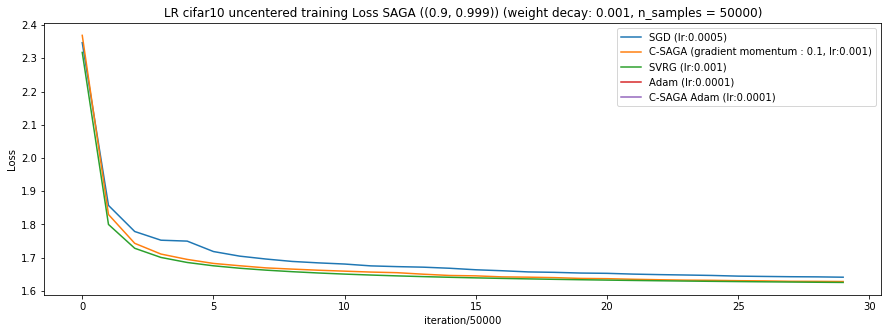

In [24]:
plot_val([model_SGD_loss, model_CSAGA_loss,
          model_SVRG_loss,model_Adam_loss,model_CSAGA_Adam_loss],
         ['SGD (lr:{})'.format(lr_SGD), 'C-SAGA (gradient momentum : {}, lr:{})'.format(MOMENTUM_SAGA,lr_CSAGA),
         'SVRG (lr:{})'.format(lr_SVRG),'Adam (lr:{})'.format(lr_Adam),'C-SAGA Adam (lr:{})'.format(lr_CSAGA_Adam)])

In [25]:
def plot_suboptimality(losses, labels,val = "Suboptimality"):
    plt.figure(figsize=(6,6))
    for loss, label in zip(losses, labels):
        plt.plot(np.asarray(loss)-optimal_loss, label = label)
    plt.legend(loc='upper right')
    plt.xlabel('iteration/{}'.format(res_step),fontsize = 25)
    plt.yticks(fontsize=13)
    plt.ylabel(val,fontsize = 25)
    #plt.ylim(0.013,0.2)
    plt.yscale('log')

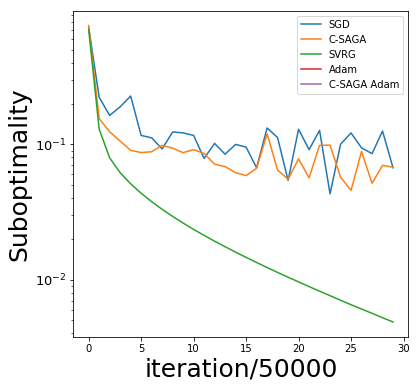

In [26]:
plot_suboptimality([model_SGD_true_loss, model_CSAGA_true_loss,model_SVRG_true_loss,
                    model_Adam_true_loss,model_CSAGA_Adam_true_loss],
         ['SGD', 'C-SAGA', 'SVRG',
         'Adam','C-SAGA Adam'])

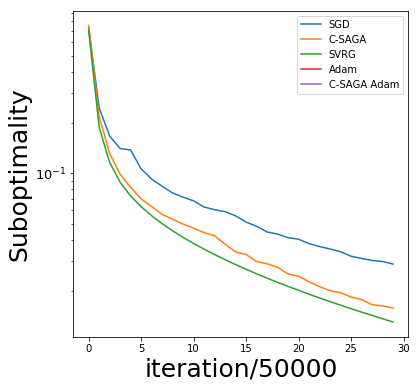

In [27]:
plot_suboptimality([model_SGD_loss, model_CSAGA_loss,model_SVRG_loss,
                    model_Adam_loss,model_CSAGA_Adam_loss],
         ['SGD', 'C-SAGA', 'SVRG',
         'Adam','C-SAGA Adam'])

In [28]:
#plot variance without hyperparam info
def plot_var(losses, labels,val = "Variance"):
    plt.figure(figsize=(6,6))
    for loss, label in zip(losses, labels):
        plt.plot(loss, label = label)
    plt.legend(loc='upper right')
    plt.xlabel('iteration/{}'.format(res_step),fontsize = 25)
    plt.yticks(fontsize=13)
    plt.ylabel(val,fontsize = 25)
    #plt.yscale('log')

In [29]:
SGD_var_plot = SGD_avg_var[::10]
CSAGA_var_plot = CSAGA_avg_var[::10]
SVRG_var_plot = SVRG_avg_var[::10]
Adam_var_plot = Adam_avg_var[::10]
CSAGA_Adam_var_plot = CSAGA_Adam_avg_var[::10]

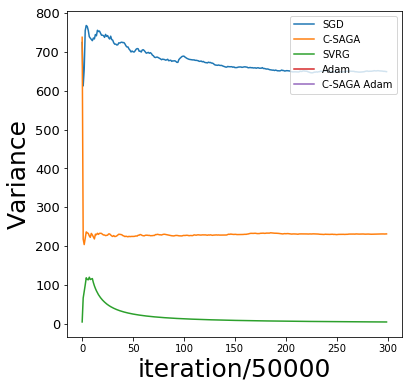

In [30]:
plot_var([SGD_var_plot,CSAGA_var_plot,SVRG_var_plot,
          Adam_var_plot,CSAGA_Adam_var_plot],
         ['SGD', 'C-SAGA', 'SVRG','Adam', 'C-SAGA Adam'])

In [31]:
#plot error without hyperparam info
def plot_error(losses, labels,val = "Error"):
    plt.figure(figsize=(6,6))
    for losses, label in zip(losses, labels):
        plt.plot(losses, label = label)
    plt.legend(loc='upper right')
    plt.xlabel('iteration/{}'.format(res_step),fontsize = 25)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel(val,fontsize = 25)
    #plt.ylim(50, 300)

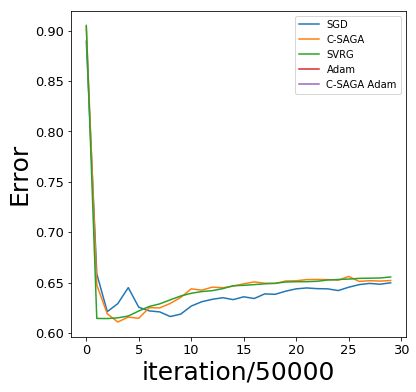

In [32]:
plot_error([model_SGD_test_e,model_CSAGA_test_e,model_SVRG_test_e,
            model_Adam_test_e,model_CSAGA_Adam_test_e],
         ['SGD', 'C-SAGA','SVRG','Adam','C-SAGA Adam'])